In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
PATH = "oat_data_2.csv"
data = pd.read_csv(PATH)

data

,year,tIV,tV,tVI,tVII,pIV,pV,pVI,pVII,yields
0,2013,7.349045,13.457325,16.721019,18.097452,34.756809,99.279384,123.914134,55.178108,27.4
1,2014,9.035669,12.496815,15.121019,19.316883,45.257158,109.534402,66.359402,90.897430,30.5
2,2015,6.907527,11.548387,15.343011,18.600000,31.000926,54.431734,48.790867,67.840274,26.5
3,2016,8.014474,13.055263,17.172000,17.902703,42.383687,54.904568,75.604560,132.000163,28.4
4,2017,6.263014,12.616438,16.793151,17.191781,75.941404,51.875614,87.479789,114.947461,29.8
5,2018,11.971831,15.518310,17.323944,18.787324,30.442483,51.478846,61.725217,107.651215,23.5
6,2019,8.604478,11.494030,20.212121,17.531818,25.032399,100.558537,39.239430,58.730420,24.9
7,2020,7.603175,10.120635,17.198413,17.620635,9.467114,82.901340,125.219463,65.232828,33.1
8,2021,5.481356,11.310000,18.348333,20.275000,46.461735,91.101709,50.826020,95.049317,31.4
9,2022,5.750000,12.987931,18.164912,18.274138,43.354483,45.753541,69.129585,87.555208,32.8


In [8]:
data.describe()

,year,tIV,tV,tVI,tVII,pIV,pV,pVI,pVII,yields
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2017.50000,7.698057,12.460513,17.239792,18.359773,38.409820,74.181967,74.828847,87.508243,28.830000
std,3.02765,1.900288,1.474451,1.471524,0.925308,17.349130,24.766855,29.638310,25.740071,3.263281
min,2013.00000,5.481356,10.120635,15.121019,17.191781,9.467114,45.753541,39.239430,55.178108,23.500000
25%,2015.25000,6.424142,11.507619,16.739052,17.691152,30.582093,52.514644,53.550820,65.884690,26.725000
50%,2017.50000,7.476110,12.556627,17.185206,18.185795,38.570248,68.902954,67.744493,89.226319,29.100000
75%,2019.75000,8.456977,13.038430,17.954670,18.740493,44.781489,97.234965,84.510982,104.500741,31.175000
max,2022.00000,11.971831,15.518310,20.212121,20.275000,75.941404,109.534402,125.219463,132.000163,33.100000


In [18]:
model_prior = CmdStanModel(stan_file='oat_yield_prior.stan')
N = len(data)
R = 1000



INFO:cmdstanpy:compiling stan file /root/Data-Analitics-Project/project/project/oat_yield_prior.stan to exe file /root/Data-Analitics-Project/project/project/oat_yield_prior


INFO:cmdstanpy:compiled model executable: /root/Data-Analitics-Project/project/project/oat_yield_prior


In [19]:
sim=model_prior.sample(data=dict(N=N, precipitation_june=data["pVI"], average_temperature_may=data["tV"]),
                     iter_sampling=R,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=True,
                     seed=42,refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


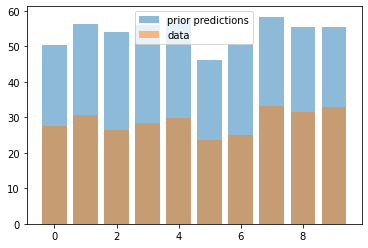

In [21]:
yields_pred_prior = sim.stan_variable("yields")
yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

t = list(range(N))

plt.bar(t, yields_pred_prior_means, alpha=0.5)
plt.bar(t, list(data["yields"]), alpha=0.5)
plt.legend(["prior predictions", "data"])
plt.show()

In [22]:
model_posterior = CmdStanModel(stan_file='oat_yield_posterior.stan')

fit = model_posterior.sample(data=dict(N=N, precipitation_june=data["pVI"], average_temperature_may=data["tV"], yields=data["yields"]), seed=42)

INFO:cmdstanpy:compiling stan file /root/Data-Analitics-Project/project/project/oat_yield_posterior.stan to exe file /root/Data-Analitics-Project/project/project/oat_yield_posterior
INFO:cmdstanpy:compiled model executable: /root/Data-Analitics-Project/project/project/oat_yield_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)











chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed

chain 3 |██████████| 


INFO:cmdstanpy:CmdStan done processing.


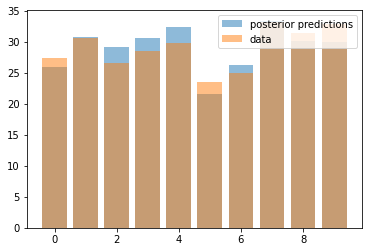

In [23]:
yields_pred_posterior = fit.stan_variable("yields_pred")
yields_pred_posterior_means = np.mean(yields_pred_posterior, axis=0)

plt.bar(t, yields_pred_posterior_means, alpha=0.5)
plt.bar(t, list(data["yields"]), alpha=0.5)
plt.legend(["posterior predictions", "data"])
plt.show()

In [24]:
a = np.mean(fit.stan_variable("a"))
b = np.mean(fit.stan_variable("b"))
c = np.mean(fit.stan_variable("c"))
d = np.mean(fit.stan_variable("d"))
print("a: " + str(a))
print("b: " + str(b))
print("c: " + str(c))
print("d: "+ str(d))

a: 19.970403625
b: 0.099591530925
c: 0.6314694682499999
d: 0.0035382739325


In [25]:
data = pd.read_csv(PATH)
N = len(data)

res = [0] * N 
for i in range(0, N):
    res[i] = a - b * (data["tV"][i] ** 2) + c * data["pVI"][i] - d * (data["pVI"][i] ** 2)

print(len(res))

10


[25.853230999748952, 30.7400536489967, 29.075264133499317, 30.513055847901004, 32.281389025384115, 21.483734027715897, 26.14360053042909, 33.361953897036365, 30.185755798731975, 29.914838170347902]


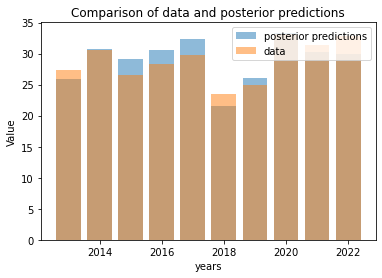

In [26]:
import matplotlib.pyplot as plt

# Tworzenie danych do wykresu
t = list(range(2013, N + 2013))  # Numery indeksów, które będziemy traktować jako wartości x
print(res)

# Tworzenie wykresu
plt.bar(t, res, alpha=0.5)  # Słupki dla danych yields_pred_posterior_means
plt.bar(t, list(data["yields"]), alpha=0.5)
plt.legend(["posterior predictions", "data"])  # Legenda
plt.xlabel('years')  # Etykieta osi x
plt.ylabel('Value')  # Etykieta osi y
plt.title('Comparison of data and posterior predictions')  # Tytuł wykresu
plt.show()  # Pokazanie wykresu

In [27]:
model_prior2 = CmdStanModel(stan_file='oat_yield_prior_2.stan')
N = len(data)
R = 1000
d = {
    "N": N,
    "precipitation_april": data["pIV"],
    "precipitation_may": data["pV"],
    "precipitation_june": data["pVI"],
    "precipitation_july": data["pVII"],
    "average_temperature_april": data["tIV"],
    "average_temperature_may": data["tV"],
    "average_temperature_june": data["tVI"],
    "average_temperature_july": data["tVII"]
}
sim=model_prior2.sample( data=d,
                     iter_sampling=R,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=True,
                     seed=42,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


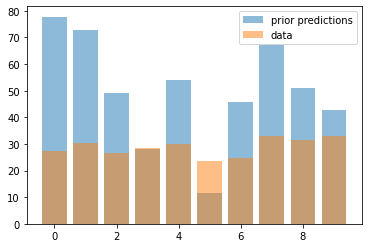

In [12]:
yields_pred_prior = sim.stan_variable("yields")
yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

t = list(range(N))

plt.bar(t, yields_pred_prior_means, alpha=0.5)
plt.bar(t, list(data["yields"]), alpha=0.5)
plt.legend(["prior predictions", "data"])
plt.show()

In [13]:
model_posterior2 = CmdStanModel(stan_file='oat_yield_posterior_2.stan')

data2 = {
    "N": N,
    "precipitation_april": data["pIV"],
    "precipitation_may": data["pV"],
    "precipitation_june": data["pVI"],
    "precipitation_july": data["pVII"],
    "average_temperature_april": data["tIV"],
    "average_temperature_may": data["tV"],
    "average_temperature_june": data["tVI"],
    "average_temperature_july": data["tVII"],
    "yields": data["yields"]
}

INFO:cmdstanpy:compiling stan file /root/Data-Analitics-Project/project/project/oat_yield_posterior_2.stan to exe file /root/Data-Analitics-Project/project/project/oat_yield_posterior_2
INFO:cmdstanpy:compiled model executable: /root/Data-Analitics-Project/project/project/oat_yield_posterior_2


In [14]:
fit2 = model_posterior2.sample(data=data2, seed=42)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)












chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▍    | 00:04 Iteration: 1000 / 2000 [ 50%]  (Warmup)





chain 1 |██████▎   | 00:05 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:06 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:07 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:08 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:08 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████ | 00:09 Iteration: 1700 / 2000 [ 85%]  (Sampling)




chain 1 |█████████▌| 00:09 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:10 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:11 Sampling completed                 


INFO:cmdstanpy:CmdStan done processing.


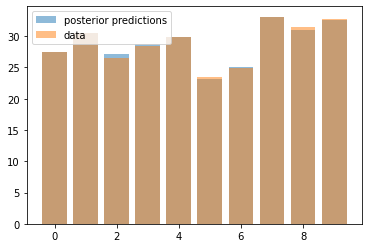

In [16]:
yields_pred_posterior = fit2.stan_variable("yields_pred")
yields_pred_posterior_means = np.mean(yields_pred_posterior, axis=0)

plt.bar(t, yields_pred_posterior_means, alpha=0.5)
plt.bar(t, list(data["yields"]), alpha=0.5)
plt.legend(["posterior predictions", "data"])
plt.show()

In [17]:
a = np.mean(fit2.stan_variable("a"))

# Średnie wartości dla tablic b, c, d
b = np.mean(fit2.stan_variable("b"), axis=0)
c = np.mean(fit2.stan_variable("c"), axis=0)
d = np.mean(fit2.stan_variable("d"), axis=0)

# Wypisanie wartości parametru a
print("a: " + str(a))

# Wypisanie wartości parametrów b, c, d dla każdego miesiąca
for i in range(4):
    print(f"b[{i+1}]: " + str(b[i]))
    print(f"c[{i+1}]: " + str(c[i]))
    print(f"d[{i+1}]: " + str(d[i]))

a: 13.298440636865
b[1]: 0.067464117970725
c[1]: 0.12450540948525
d[1]: 0.00251648224888075
b[2]: 0.034515066729525
c[2]: -0.23986933898749999
d[2]: -0.00176853612790375
b[3]: 0.00026861852430350007
c[3]: -0.032390004110975
d[3]: -0.00058967610873927
b[4]: 0.041378476891625
c[4]: 0.9285079770237501
d[4]: 0.004441409279925001
